![](header.png)

In [1]:
from heapq import heappush, heappop
import networkx as nx
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image
from dotenv import dotenv_values
from cities import *
import time
from itertools import permutations
GMAPS_API_KEY = dotenv_values(".env")["GMAPS_API_KEY"]

In [2]:
def path_to_graph(adjacency_list, path, pos, heuristic=None):
    G = nx.Graph()

    for node in adjacency_list:
        G.add_node(node)

    for node in adjacency_list:
        for neighbor in adjacency_list[node]:
            G.add_edge(node, neighbor, weight=adjacency_list[node][neighbor])

    nx.draw(G, pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    node_labels = {node: f"{node}\n{heuristic[node]}" if heuristic else f"{node}" for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=node_labels)

    path_edges = list(zip(path, path[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=2)


In [3]:
def a_star_search(graph, start, goal, heuristics):
    queue = []
    # print(f"Searching path from {start} to {goal} using heuristic {heuristics}")
    heappush(queue, (heuristics[start], start, [start], 0))  # Initialize g_cost to 0
    visited = set()

    while queue:
        # print(queue)
        (f_cost, current, path, g_cost) = heappop(queue)
        if current in visited:
            continue
        if current == goal:
            return path, g_cost  # Return actual accumulated cost
        visited.add(current)
        for neighbor in graph[current]:
            if neighbor not in visited:
                tentative_g_cost = g_cost + graph[current][neighbor]
                f_cost = tentative_g_cost + heuristics[neighbor]
                # print('Pushing to queue:', f_cost, neighbor, path + [neighbor], tentative_g_cost)
                heappush(queue, (f_cost, neighbor, path + [neighbor], tentative_g_cost))
    return None, float('inf')

In [4]:
def greedy_search(graph, start, goal, heuristics):
    queue = []
    # print(f"Searching path from {start} to {goal} using heuristic {heuristics}")
    heappush(queue, (heuristics[start], start, [start], 0))  # Initialize with zero cost
    visited = set()

    while queue:
        # print(queue)
        (heuristic, current, path, cost) = heappop(queue)
        if current in visited:
            continue
        visited.add(current)
        if current == goal:
            return path, cost  # Return the actual cost without heuristic
        for neighbor in graph[current]:
            if neighbor not in visited:
                total_cost = cost + graph[current][neighbor]  # Accumulate the actual cost
                # print('Pushing to queue:', (heuristics[neighbor], neighbor, path + [neighbor], total_cost))
                heappush(queue, (heuristics[neighbor], neighbor, path + [neighbor], total_cost))
    return None, float('inf')

In [5]:
def show_map(map_url):
    response = requests.get(map_url)
    fig = plt.figure(figsize=(10, 8))
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [6]:
def path_to_map(GMAPS_API_KEY, path, lat_long, attractions, must_visit=[]):
    map_url = f"""https://maps.googleapis.com/maps/api/staticmap?center=-25.77258916306187,-50.18262294971848&scale=2&zoom=8&size=600x400&maptype=roadmap&key={GMAPS_API_KEY}&path=color:0xff0000|weight:5|"""
    for i, node in enumerate(path):
        lat, long = lat_long[node]
        map_url += f"{lat},{long}|" if i < len(path) - 1 else f"{lat},{long}"
    for i, node in enumerate(path):
        lat, long = lat_long[node]
        if i == 0:
            map_url += f"&markers=color:red|label:A|{lat},{long}"
        elif i == len(path) - 1:
            map_url += f"&markers=color:green|label:D|{lat},{long}"
        else:
            if node in must_visit:
                map_url += f"&markers=anchor:center|icon:https://emojiapi.dev/api/v1/{attractions[node]['Marker']}/64.png|label:{node[0]}|{lat},{long}"
    return map_url

# A* Search Algorithm

Path: ['Porto União', 'São Mateus', 'Lapa', 'Contenda', 'Araucária', 'Curitiba'], Cost: 228


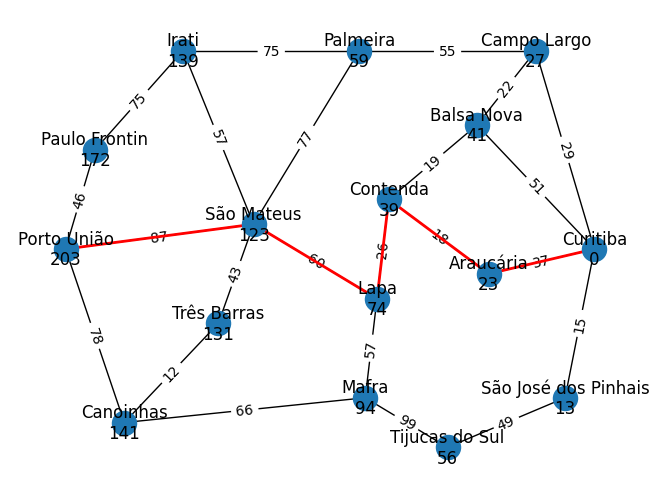

In [7]:
# A* Search Algorithm
start_node = "Porto União"
goal_node = "Curitiba"
path, cost = a_star_search(adjacency_list, start_node, goal_node, straight_line_distance['Curitiba'])
print(f"Path: {path}, Cost: {cost}")

path_to_graph(adjacency_list, path, graph_positions, straight_line_distance['Curitiba'])

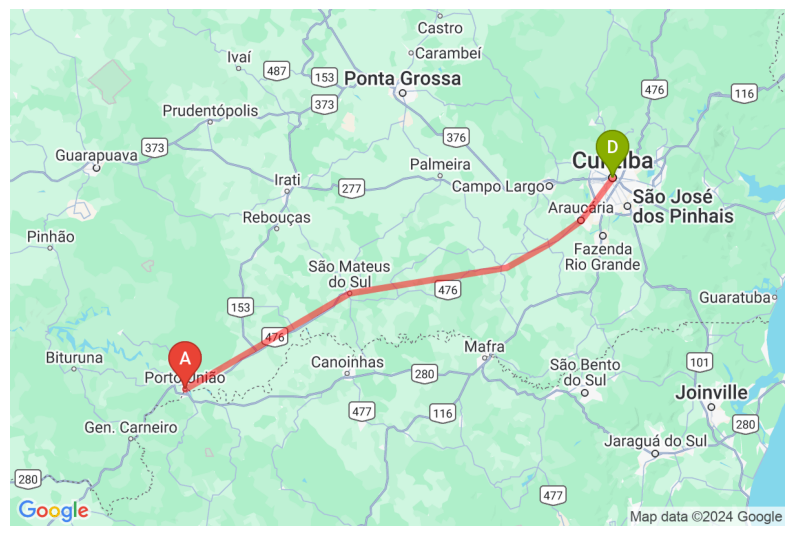

In [8]:
map_url = path_to_map(GMAPS_API_KEY, path, lat_long, attractions)
show_map(map_url)

# Greedy Search Algorithm

Path: ['Porto União', 'São Mateus', 'Palmeira', 'Campo Largo', 'Curitiba'], Cost: 248


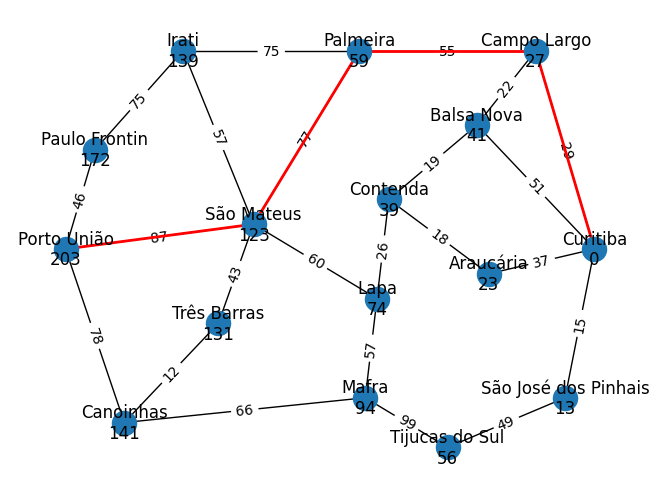

In [9]:
# Greedy Search Algorithm

start_node = "Porto União"
goal_node = "Curitiba"
path, cost = greedy_search(adjacency_list, start_node, goal_node, straight_line_distance['Curitiba'])
print(f"Path: {path}, Cost: {cost}")

path_to_graph(adjacency_list, path, graph_positions, straight_line_distance['Curitiba'])

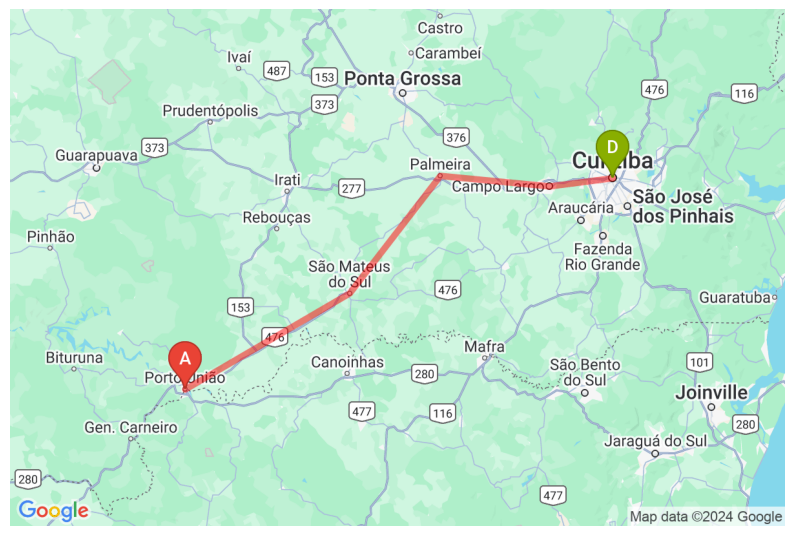

In [10]:
map_url = path_to_map(GMAPS_API_KEY, path, lat_long, attractions)
show_map(map_url)

# Open Traveling Salesmen (to selected attractions)

In [11]:
def optimal_path(graph, start, must_visit, end, search, heuristics):
    min_cost = float('inf')
    best_path = None
    if start in must_visit:
        must_visit.remove(start)
    if end in must_visit:
        must_visit.remove(end)
        
    for perm in permutations(must_visit):
        nodes = [start] + list(perm) + [end]
        print(nodes)
        total_path = []
        total_cost = 0
        valid_path = True

        for i in range(len(nodes) - 1):
            path, cost = search(graph, nodes[i], nodes[i+1], heuristics[nodes[i+1]])
            if path is None:
                valid_path = False
                break
            if total_path and path:
                total_path.extend(path[1:])
            else:
                total_path.extend(path)
            total_cost += cost

        print(total_cost)

        if valid_path and total_cost < min_cost:
            min_cost = total_cost
            best_path = total_path
    print(f"Optimal path: {best_path}, Cost: {min_cost}")
    return best_path, min_cost

## Greedy Search (Basic Plan)

In [12]:
must_visit = {'Mafra', 'Palmeira', 'Irati'}
start = "Porto União"
end = "Curitiba"
search = greedy_search
path, cost = optimal_path(adjacency_list, start, must_visit, end, search, haversine_distance_matrix)

['Porto União', 'Mafra', 'Palmeira', 'Irati', 'Curitiba']
557
['Porto União', 'Mafra', 'Irati', 'Palmeira', 'Curitiba']
481
['Porto União', 'Palmeira', 'Mafra', 'Irati', 'Curitiba']
695
['Porto União', 'Palmeira', 'Irati', 'Mafra', 'Curitiba']
576
['Porto União', 'Irati', 'Mafra', 'Palmeira', 'Curitiba']
581
['Porto União', 'Irati', 'Palmeira', 'Mafra', 'Curitiba']
576
Optimal path: ['Porto União', 'Canoinhas', 'Mafra', 'Canoinhas', 'Três Barras', 'São Mateus', 'Irati', 'Palmeira', 'Campo Largo', 'Curitiba'], Cost: 481


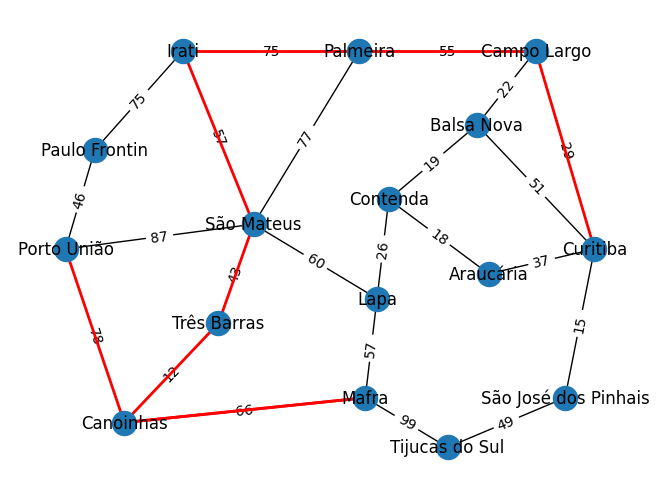

In [13]:
path_to_graph(adjacency_list, path, graph_positions)

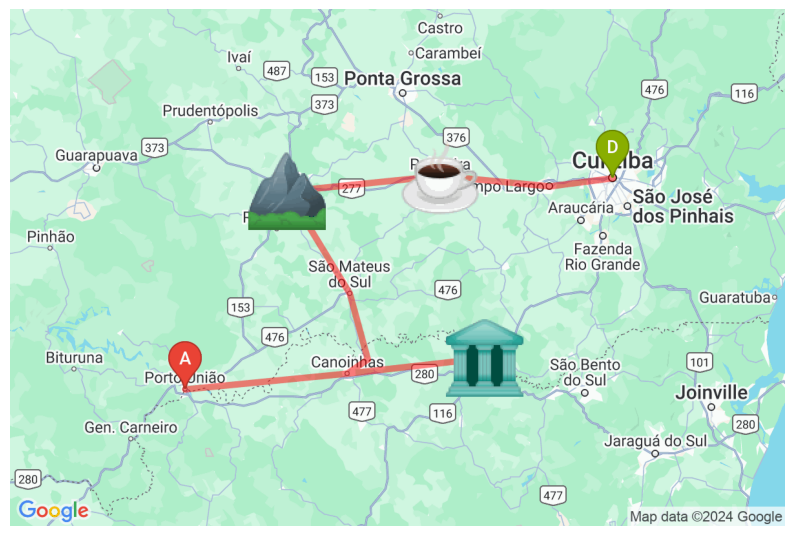

In [14]:
map_url = path_to_map(GMAPS_API_KEY, path, lat_long, attractions, must_visit)
show_map(map_url)

## A* Search (Premium Plan)

In [15]:
search = a_star_search
path, cost = optimal_path(adjacency_list, start, must_visit, end, search, haversine_distance_matrix)

['Porto União', 'Mafra', 'Palmeira', 'Irati', 'Curitiba']
557
['Porto União', 'Mafra', 'Irati', 'Palmeira', 'Curitiba']
477
['Porto União', 'Palmeira', 'Mafra', 'Irati', 'Curitiba']
676
['Porto União', 'Palmeira', 'Irati', 'Mafra', 'Curitiba']
551
['Porto União', 'Irati', 'Mafra', 'Palmeira', 'Curitiba']
558
['Porto União', 'Irati', 'Palmeira', 'Mafra', 'Curitiba']
513
Optimal path: ['Porto União', 'Canoinhas', 'Mafra', 'Lapa', 'São Mateus', 'Irati', 'Palmeira', 'Campo Largo', 'Curitiba'], Cost: 477


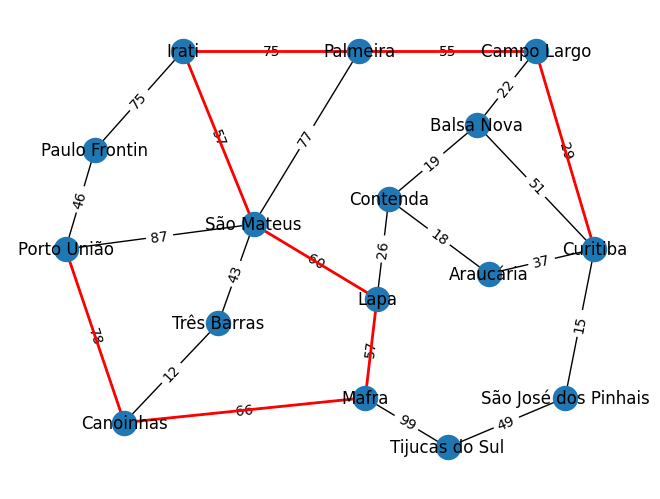

In [16]:
path_to_graph(adjacency_list, path, graph_positions)

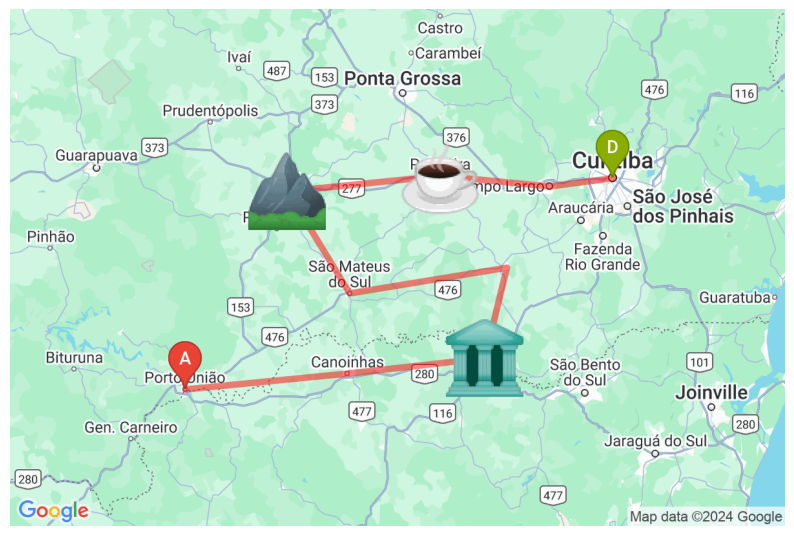

In [17]:
map_url = path_to_map(GMAPS_API_KEY, path, lat_long, attractions, must_visit)
show_map(map_url)

# Fully connected graph (Helicopter)

In [18]:
path, cost = optimal_path(fully_connected_graph, start, must_visit, end, search, haversine_distance_matrix)

['Porto União', 'Mafra', 'Palmeira', 'Irati', 'Curitiba']
413.0
['Porto União', 'Mafra', 'Irati', 'Palmeira', 'Curitiba']
378.0
['Porto União', 'Palmeira', 'Mafra', 'Irati', 'Curitiba']
470.0
['Porto União', 'Palmeira', 'Irati', 'Mafra', 'Curitiba']
411.0
['Porto União', 'Irati', 'Mafra', 'Palmeira', 'Curitiba']
359.0
['Porto União', 'Irati', 'Palmeira', 'Mafra', 'Curitiba']
335.0
Optimal path: ['Porto União', 'Irati', 'Palmeira', 'Mafra', 'Araucária', 'Curitiba'], Cost: 335.0


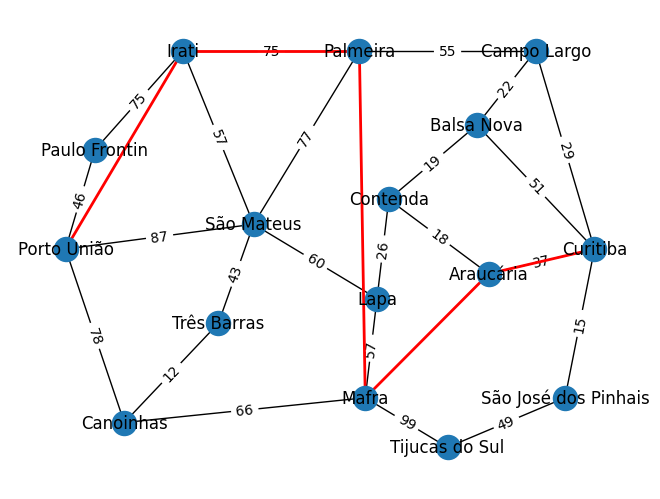

In [19]:
path_to_graph(adjacency_list, path, graph_positions)

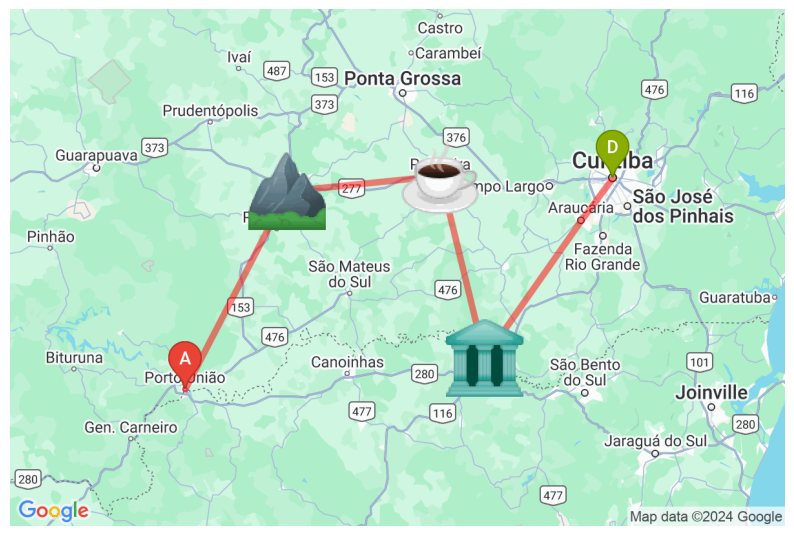

In [20]:
map_url = path_to_map(GMAPS_API_KEY, path, lat_long, attractions, must_visit)
show_map(map_url)

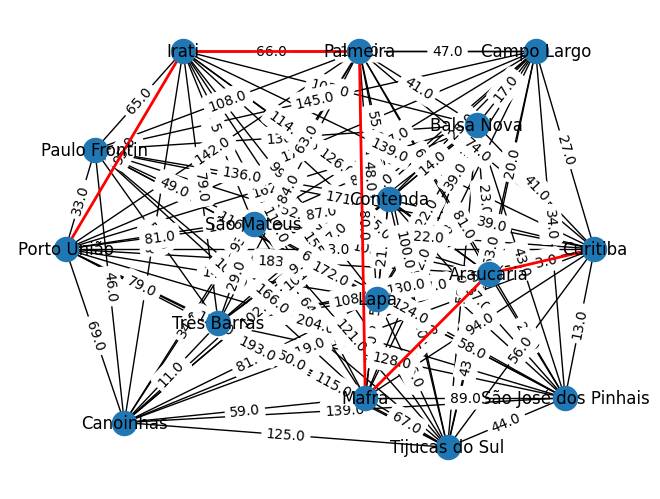

In [21]:
path_to_graph(fully_connected_graph, path, graph_positions)